In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [151]:
#database connection settings
import psycopg2

db_name = "traviato_development"
db_host = "localhost"
db_port = "5432"
db_user = "lievgarcia"
db_pwd = "traviato81"

conn = psycopg2.connect(database=db_name, user=db_user, password=db_pwd, host=db_host, port=db_port)

In [207]:
import pandas as pd

columns=['source_id', 'source_name', 'composer', 'work', 'country', 'state', 'city', 'theatre', 
         'date_start', 'date_end', 'premiere_date', 'performance_count', 'composer_country', 'theatre_category']

cursor = conn.cursor()  
query = "SELECT s.id as source_id, " + \
        "       s.name as source_name, " + \
        "       coalesce(c.name, l.composer) as composer, " + \
        "       coalesce(w.name, l.work) as work, " + \
        "       l.country, " + \
        "       l.state, " + \
        "       l.city, " + \
        "       l.theatre, " + \
        "       l.date_start, " + \
        "       l.date_end, " + \
        "       w.premiere_date, " + \
        "       l.performance_count, " + \
        "       c.country as composer_country, " + \
        "       CASE WHEN l.source_id = 1 then 'Professional' when opera_america_name IS NULL THEN 'Amateur' ELSE 'Professional' END as theatre_category " + \
        "from sources s " + \
        "INNER JOIN listings l on s.id = l.source_id " + \
        "LEFT JOIN theatre_mapping tm ON l.theatre = tm.name " + \
        "LEFT JOIN listing_mappers lm ON l.map_key = lm.map_key " + \
        "LEFT JOIN works w ON lm.work_uri = w.uri " + \
        "LEFT JOIN composers c ON w.composer_id = c.id " + \
        "WHERE w.uri != 'W1' " + \
        "ORDER BY s.id DESC, l.country, l.state, l.city"
        
cursor.execute(query)

mdf = pd.DataFrame(cursor.fetchall(), columns=columns)
mdf['year'] = mdf.apply(lambda row: row['date_start'].year, axis=1)
mdf['decade'] = mdf.apply(lambda row: 10*int(row['year']/10), axis=1)
mdf[['premiere_date']] = mdf[['premiere_date']].fillna(value=0)
mdf['work_decade'] = mdf.apply(lambda row: 10*int(row['premiere_date']/10), axis=1)


In [201]:
######################## libraries ########################

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import numpy as np

import sys
sys.path.append('../../')

from utils.utility_functions import label_top
from utils.utility_functions import get_last_name
from utils.utility_functions import make_dash_zero

##################### CHARTING OPTIONS #####################

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Palatino']})

rc('text', usetex=True)
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

colors = ['#8a170f', '#8a540f', '#828a0f', '#458a0f', '#0f8a17', '#0f8a54', '#0f828a', '#0f458a', '#170f8a', '#540f8a', '#8a0f82', '#8a0f45']


##################### SOURCES OPTIONS #####################

archival_sources = ['Metropolitan Opera', 'Opera Scotland', 'Royal Opera House', 'Teatro alla Scala', 'Wiener Staatsoper']
commercial_sources_world = ['bachtrack.com','operabase.com','operacritic.com']
commercial_sources_uk = ['Concert-Diary','U.K. Theatre Web']
government_sources = ['National Central Opera Service Reports', 'Opera America']

##############################################################################

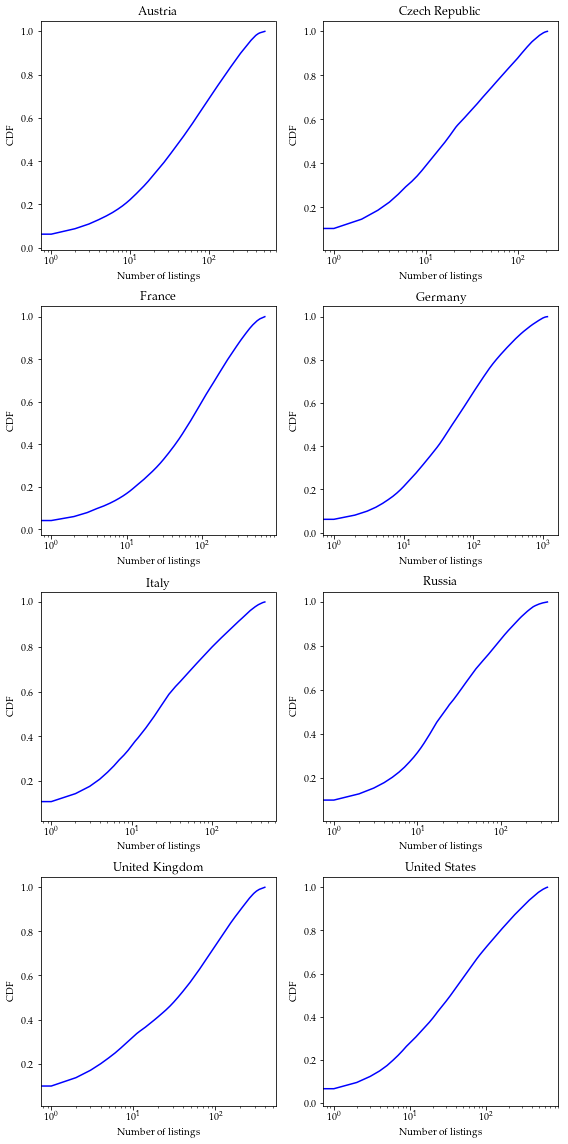

In [219]:
######################## WORLD           ########################
######################## CDF per country ########################

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(commercial_sources_world)]
o_df = o_df[o_df['year'] > 2007]
o_df = o_df[['composer', 'work', 'country', 'state', 'city', 'date_start', 'date_end', 'premiere_date', 'performance_count', 'year', 'decade', 'work_decade', 'composer_country']]
o_df = o_df.drop_duplicates()

countries_incl = ['Germany', 'United States', 'United Kingdom', 'Austria', 'France', 'Russia', 'Italy', 'Czech Republic']

o_df = o_df[o_df['country'].isin(countries_incl)]
countries = o_df['country'].unique().tolist()

fig = plt.figure(figsize=(8, 16))

for num, country in enumerate(countries):

    c_df = o_df[o_df['country']==country]
    
    c_df = c_df.groupby(['composer', 'work'])
    c_df = c_df.agg({'performance_count': np.sum })
    c_df = c_df.reset_index(level=['composer', 'work'])
    c_df = c_df.sort_values(by=['performance_count'], ascending=False)
    c_df = c_df.reset_index()    
    
    X  = c_df.index.values
    Y  = c_df['performance_count'].values.astype(float)

    # Normalize the data to a proper PDF
    Y /= Y.sum()
    # Compute the CDF
    CY = np.cumsum(Y)

    # Plot CDF
    plt.subplot(420+num+1)
    plot(X,CY)    
    plt.ylabel('CDF')
    plt.xlabel('Number of listings')
    ax = plt.gca()
    ax.set_xscale("log", nonposx='clip')
    ax.set_title(country)  
    
plt.tight_layout()
plt.show()
    
###############################################################

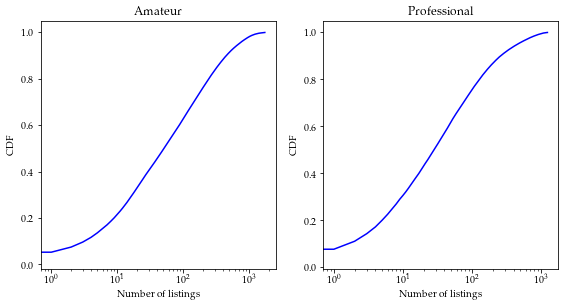

In [211]:
######################## US Government  ########################
######################## CDF per theatre category ########################

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(government_sources)]
o_df.loc[o_df['theatre']=='New York City Opera', 'theatre_category'] = 'Professional'

categories = o_df['theatre_category'].unique().tolist()

fig = plt.figure(figsize=(8, 16))

for num, category in enumerate(categories):

    c_df = o_df[o_df['theatre_category']==category]
    
    c_df = c_df.groupby(['composer', 'work'])
    c_df = c_df.agg({'performance_count': np.sum })
    c_df = c_df.reset_index(level=['composer', 'work'])
    c_df = c_df.sort_values(by=['performance_count'], ascending=False)
    c_df = c_df.reset_index() 
    
    X  = c_df.index.values
    Y  = c_df['performance_count'].values.astype(float)

    # Normalize the data to a proper PDF
    Y /= Y.sum()
    # Compute the CDF
    CY = np.cumsum(Y)

    # Plot CDF
    plt.subplot(420+num+1)
    plot(X,CY)    
    plt.ylabel('CDF')
    plt.xlabel('Number of listings')
    ax = plt.gca()
    ax.set_xscale("log", nonposx='clip')
    ax.set_title(category)    
    
plt.tight_layout()
plt.show()
    
###############################################################

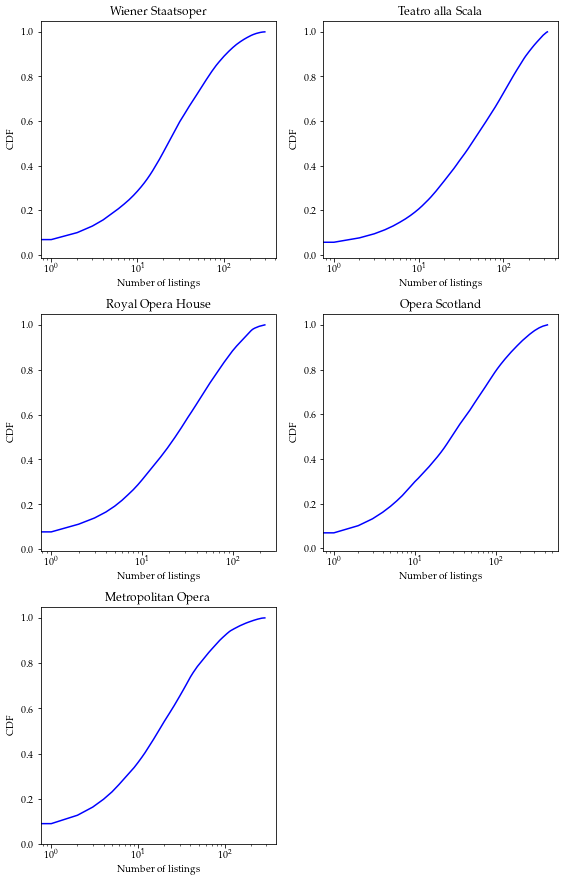

In [218]:
######################## Archive Sources  ########################
######################## CDF per source ########################

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(archival_sources)]

sources = o_df['source_name'].unique().tolist()

fig = plt.figure(figsize=(8, 16))

for num, source in enumerate(sources):

    c_df = o_df[o_df['source_name']==source]
    
    c_df = c_df.groupby(['composer', 'work'])
    c_df = c_df.agg({'performance_count': np.sum })
    c_df = c_df.reset_index(level=['composer', 'work'])
    c_df = c_df.sort_values(by=['performance_count'], ascending=False)
    c_df = c_df.reset_index() 
    
    X  = c_df.index.values
    Y  = c_df['performance_count'].values.astype(float)

    # Normalize the data to a proper PDF
    Y /= Y.sum()
    # Compute the CDF
    CY = np.cumsum(Y)

    # Plot CDF
    plt.subplot(420+num+1) 
    plot(X,CY)        
    plt.ylabel('CDF')
    plt.xlabel('Number of listings')
    ax = plt.gca()
    ax.set_xscale("log", nonposx='clip')
    ax.set_title(source)    
    
plt.tight_layout()
plt.show()
    
###############################################################

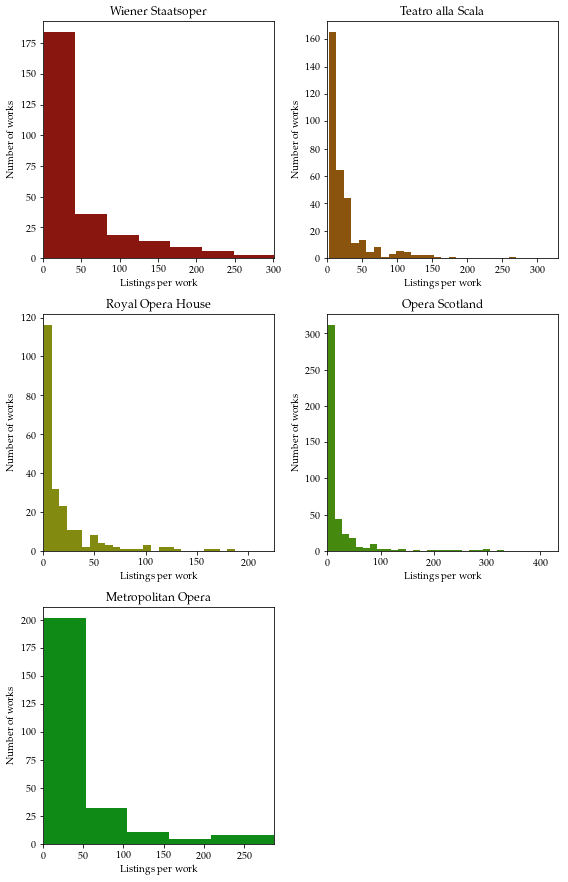

In [221]:
######################## Archive Sources  ########################
######################## Histogram per source ########################

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(archival_sources)]

sources = o_df['source_name'].unique().tolist()
# print(sources)
# source = 'Wiener Staatsoper'
fig = plt.figure(figsize=(8, 16))

for num, source in enumerate(sources):

    c_df = o_df[o_df['source_name']==source]
    
    c_df = c_df.groupby(['composer', 'work'])
    c_df = c_df.agg({'performance_count': np.sum })
    c_df = c_df.reset_index(level=['composer', 'work'])
    c_df = c_df.sort_values(by=['performance_count'], ascending=False)
    c_df = c_df.reset_index() 
    c_df = c_df.rename({'performance_count': 'Listings'}, axis='columns')
    
    plt.subplot(420+num+1)
    plt.hist([c_df['Listings']], bins=25, color=colors[num]);
    axes = plt.gca()
    axes.get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    axes.set_title(source)    
    plt.ylabel('Number of works')
    plt.xlabel('Listings per work')
    left_edge = 0
    right_edge = c_df.index[-1]
    axes.set_xlim(left_edge, right_edge)    

plt.tight_layout()
plt.show()

###############################################################

In [269]:
######################## Archive Sources  ########################
######################## CDF per source ########################

o_df = mdf.copy()
o_df = o_df[o_df['source_name'].isin(archival_sources)]

sources = o_df['source_name'].unique().tolist()

c_df = o_df[o_df['source_name']=='Wiener Staatsoper']    
c_df = c_df.groupby(['composer', 'work'])
c_df = c_df.agg({'performance_count': np.sum })
c_df = c_df.reset_index(level=['composer', 'work'])
c_df = c_df.sort_values(by=['performance_count'], ascending=False)
c_df = c_df.reset_index() 
    
X  = c_df.index.values
Y  = c_df['performance_count'].values.astype(float)

print(c_df.head())
# Normalize the data to a proper PDF
# Y /= Y.sum()
# Compute the CDF
# CY = np.cumsum(Y)

Y
###############################################################

   index                 composer                    work  performance_count
0    134          Giacomo Puccini                   Tosca               1033
1    298  Wolfgang Amadeus Mozart  The Marriage of Figaro               1028
2    297  Wolfgang Amadeus Mozart         The Magic Flute                953
3    252          Richard Strauss       Der Rosenkavalier                893
4    125        Giacomo Meyerbeer           Les Huguenots                843


array([  1.03300000e+03,   1.02800000e+03,   9.53000000e+02,
         8.93000000e+02,   8.43000000e+02,   8.37000000e+02,
         6.74000000e+02,   6.42000000e+02,   5.96000000e+02,
         5.90000000e+02,   5.78000000e+02,   5.66000000e+02,
         5.57000000e+02,   5.54000000e+02,   5.52000000e+02,
         5.48000000e+02,   5.47000000e+02,   5.20000000e+02,
         5.01000000e+02,   4.94000000e+02,   4.88000000e+02,
         4.63000000e+02,   4.55000000e+02,   4.19000000e+02,
         3.91000000e+02,   3.90000000e+02,   3.77000000e+02,
         3.53000000e+02,   3.40000000e+02,   3.34000000e+02,
         3.28000000e+02,   3.08000000e+02,   2.57000000e+02,
         2.52000000e+02,   2.46000000e+02,   2.44000000e+02,
         2.40000000e+02,   2.35000000e+02,   2.22000000e+02,
         2.12000000e+02,   2.06000000e+02,   1.92000000e+02,
         1.89000000e+02,   1.86000000e+02,   1.81000000e+02,
         1.77000000e+02,   1.71000000e+02,   1.70000000e+02,
         1.68000000e+02,

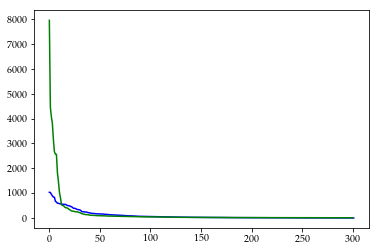

In [553]:
from scipy.stats import zipf

r = zipf.rvs(1.7, size=2000)
r.sort()
r = r[::-1]
r = r[4:305]

plt.plot(Y)
plt.plot(r)
# plt.plot(Z)

plt.show()

In [546]:
r

array([5494, 2571, 2407, 1885, 1315, 1000,  979,  729,  609,  553,  517,
        508,  508,  501,  489,  462,  434,  414,  361,  347,  340,  332,
        312,  307,  294,  287,  259,  241,  213,  213,  202,  182,  163,
        152,  147,  144,  143,  140,  134,  126,  122,  121,  110,  106,
        106,  105,  104,   96,   94,   93,   87,   85,   84,   84,   81,
         81,   81,   78,   77,   75,   75,   72,   71,   70,   67,   67,
         66,   65,   64,   64,   64,   63,   62,   61,   60,   59,   59,
         58,   58,   57,   57,   57,   56,   56,   55,   53,   52,   50,
         48,   47,   47,   46,   46,   45,   45,   44,   44,   43,   43,
         43,   42,   41,   41,   41,   41,   41,   40,   40,   40,   40,
         39,   38,   38,   38,   37,   37,   37,   36,   36,   36,   36,
         36,   35,   35,   35,   34,   33,   33,   33,   32,   32,   30,
         30,   30,   30,   29,   29,   29,   29,   28,   28,   28,   28,
         27,   26,   25,   25,   25,   25,   25,   

In [554]:
from scipy.stats import zipf
r = zipf.rvs(1.7, size=1000)
r.sort()
r

a = 6.5
rv = zipf(a)

In [563]:
rv.pmf(100)

9.8813653172392856e-14